In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy 
import pandas as pd
import time
import datetime

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


# Data Preprocessing

In [2]:
Dataset = r'../scripts/Data/TexasBlackout.csv'
fulldata = pd.read_csv(Dataset, thousands=',') 

In [3]:
fulldata['Outage %'] = fulldata['Outage %'].str.rstrip('%').astype('float') / 100.0

In [4]:
fulldata

,ID,County,Customers Tracked,Customers Out,Outage %,DateTime
0,1510,Dallam,5727,0,0.0,2021-02-17 01:55:55.281883
1,1734,Sherman,2992,0,0.0,2021-02-17 01:55:58.352994
2,1762,Hansford,5098,0,0.0,2021-02-17 01:56:01.411124
3,1801,Ochiltree,8959,0,0.0,2021-02-17 01:56:04.414076
4,1858,Lipscomb,4164,0,0.0,2021-02-17 01:56:06.654780
...,...,...,...,...,...,...
204138,1581,Camp,8126,0,0.0,2021-02-26 19:39:04.719373
204139,1454,Rains,11095,0,0.0,2021-02-26 19:39:06.938395
204140,1329,Aransas,19503,0,0.0,2021-02-26 19:39:10.250157
204141,1481,Travis,627720,6,0.0,2021-02-26 19:39:13.562152


In [5]:
fulldata['Outage %'].describe()

count    204143.000000
mean          0.031026
std           0.095192
min           0.000000
25%           0.000000
50%           0.000000
75%           0.003200
max           0.946000
Name: Outage %, dtype: float64

In [6]:
fulldata.keys()

Index(['ID', 'County', 'Customers Tracked', 'Customers Out', 'Outage %',
       'DateTime'],
      dtype='object')

In [7]:
sorteddata=fulldata.sort_values(by = ['ID', 'DateTime'])

In [8]:
ids=sorteddata['ID'].unique().tolist()

In [9]:
print(len(ids))

253


In [10]:
blackout_data = []
# def convertDate(d):
#     d = pd.to_datetime(d[:-3])
#     return d 

for i in range(len(ids)):
    blackout_data.append(sorteddata.loc[sorteddata.ID==ids[i]])
    
    blackout_data[i] = blackout_data[i].reset_index().drop(columns=['index'])
    # blackout_data[i]['DateTime'] = blackout_data[i]['DateTime'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    # blackout_data[i]['15min_ints'] =  blackout_data[i]['local_15min'].map(mdates.date2num)

In [11]:
blackout_data[0]

,ID,County,Customers Tracked,Customers Out,Outage %,DateTime
0,1326,Anderson,24799,525,0.0212,2021-02-17 02:02:29.849683
1,1326,Anderson,24799,525,0.0212,2021-02-17 02:15:30.773378
2,1326,Anderson,24799,549,0.0221,2021-02-17 02:28:25.200753
3,1326,Anderson,24799,549,0.0221,2021-02-17 02:41:24.546364
4,1326,Anderson,24799,549,0.0221,2021-02-17 02:54:50.976373
...,...,...,...,...,...,...
803,1326,Anderson,24800,0,0.0000,2021-02-26 18:19:46.974491
804,1326,Anderson,24800,0,0.0000,2021-02-26 18:38:09.083511
805,1326,Anderson,24800,0,0.0000,2021-02-26 18:56:12.414498
806,1326,Anderson,24800,0,0.0000,2021-02-26 19:14:41.210969


In [12]:
max_size = 0
max_i = 0
min_size = np.inf
min_i = 0
for i in range(len(ids)):
    size=len(blackout_data[i])
    if size > max_size:
        max_i = i
        max_size = size 
    if size < min_size:
        min_i = i
        min_size = size
print(f'max_i: {max_i}, max_size: {max_size}')
print(f'min_i: {min_i}, min_size: {min_size}')

max_i: 177, max_size: 815
min_i: 3, min_size: 798


In [13]:
#get largest outrages 
large_outrage_list =[]
large_outrage_i_list = []
threshold = .70

for i in range(len(ids)):
    highoutage=max(blackout_data[i]['Outage %'])
    if highoutage > threshold:
        large_outrage_list.append(highoutage)
        large_outrage_i_list.append(i)
print(large_outrage_list)
print(len(large_outrage_list))

[0.9264, 0.8837, 0.7367, 0.7763, 0.8686, 0.8190999999999999, 0.7173, 0.752, 0.946, 0.7827, 0.8416, 0.8601000000000001, 0.8304, 0.8954000000000001, 0.7152, 0.7804000000000001]
16


Text(0, 0.5, 'Outage %')

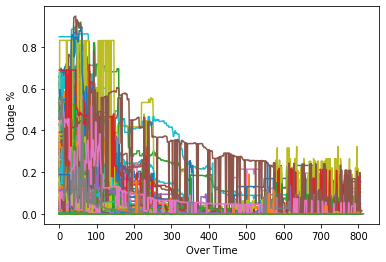

In [15]:
for i in range(len(ids)):
    plt.plot(blackout_data[i]['Outage %'])

plt.xlabel('Over Time')
plt.ylabel('Outage %')

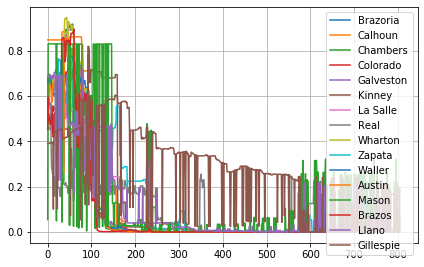

In [16]:
for i in large_outrage_i_list:
    plt.plot(blackout_data[i]['Outage %'], label= f'{ blackout_data[i]["County"][0] }')
plt.legend()
plt.grid(True)
plt.tight_layout()

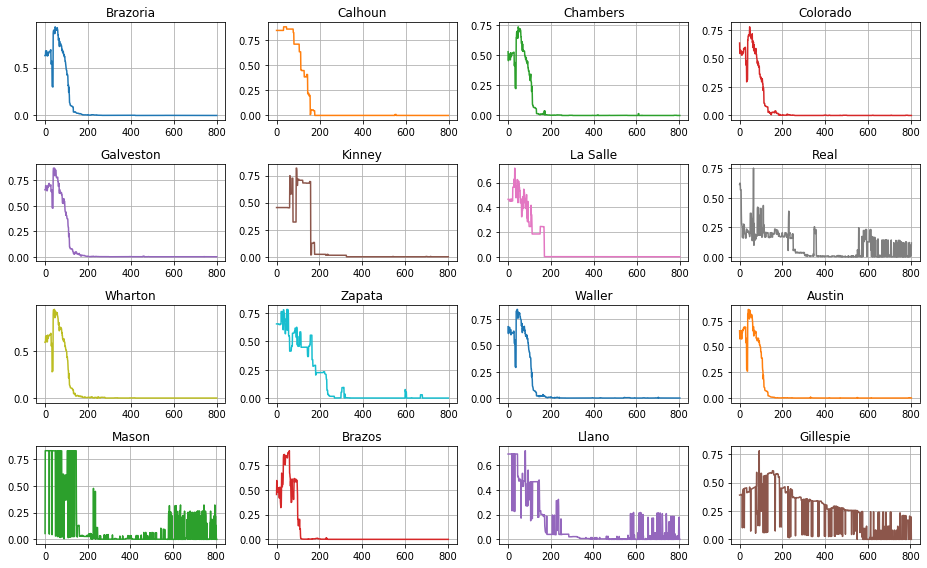

In [17]:
plt.figure(figsize=(13, 8))
for i, j in enumerate(large_outrage_i_list):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(4,4,i+1) 
    plt.plot(blackout_data[j]['Outage %'], color = f'C{i}')
    plt.title(f'{blackout_data[j]["County"][0]}')
    plt.grid(True)
plt.tight_layout()

In [18]:
for i,val in enumerate(blackout_data):
    if "Montgomery" in val['County'][0]:
        print(i)
    

117


In [19]:
blackout_data[68]['Outage %'].describe()

count    804.000000
mean       0.019084
std        0.047101
min        0.000000
25%        0.000000
50%        0.000100
75%        0.000800
max        0.186800
Name: Outage %, dtype: float64

In [20]:
blackout_data[55]['Outage %'].describe()

count    802.000000
mean       0.056850
std        0.140152
min        0.000000
25%        0.000000
50%        0.000300
75%        0.002700
max        0.560200
Name: Outage %, dtype: float64

In [21]:
blackout_data[117]['Outage %'].describe()

count    805.000000
mean       0.035786
std        0.082719
min        0.000000
25%        0.000100
50%        0.000300
75%        0.006200
max        0.323800
Name: Outage %, dtype: float64